In [104]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [105]:
class Team:
    team_id = 0

    def __init__(self, founder):
        self.founder = founder
        self.members = {founder}
        self.a = random.uniform(0, 0.5)
        self.b = random.uniform(0.75, 1.25)
        self.beta = random.uniform(1.5, 2)
        self.id = Team.team_id
        Team.team_id += 1

    def output(self, effort, total_effort_prev):
        total_effort = total_effort_prev + effort
        return self.a * total_effort + self.b * total_effort ** self.beta

    def add_member(self, agent):
        self.members.add(agent)

    def remove_member(self, agent):
        self.members.remove(agent)

In [106]:
class Agent:
    agent_id = 0

    def __init__(self, theta, omega, network, birth_period = -1):
        self.theta = theta
        self.omega = omega
        self.network = network
        self.team = None
        self.effort = 0
        self.utility = 0
        self.birth_period = birth_period
        self.id = Agent.agent_id
        Agent.agent_id += 1

    def choose_effort(self, team, total_effort_prev):
        def utility(effort):
            leisure = self.omega - effort
            consumption = team.output(effort, total_effort_prev) / len(team.members) if team else 0
            return consumption ** self.theta * leisure ** (1 - self.theta)

        def negative_utility(effort):
            return -utility(effort)

        res = minimize(negative_utility, self.omega / 2, bounds=[(0, self.omega)])
        self.effort = res.x[0]
        self.utility = -res.fun

    def choose_team(self, teams):
        # Вычислить е* и U(е*) в текущей фирме
        if self.team is not None:
            self.choose_effort(self.team, sum(a.effort for a in self.team.members) if self.team else 0)
        current_utility = self.utility
        # Вычислить е* и U(е*) во вновь создаваемой фирме
        new_team = Team(self)
        self.choose_effort(new_team, 0)
        startup_utility = self.utility
        best_utility = max(current_utility, startup_utility)
        best_team = self.team if current_utility >= startup_utility else new_team

        # ДЛЯ каждой фирмы в социальной сети агента
        for friend in self.network:
            if friend.team and friend.team != self.team:
                # Вычислить е* и U(e*)
                self.choose_effort(friend.team, sum(a.effort for a in friend.team.members))
                if self.utility > best_utility:
                    best_utility = self.utility
                    best_team = friend.team

        # ЕСЛИ текущая фирма - не лучший вариант, покинуть ее
        if self.team != best_team:
            if self.team:
                #print(f"I leave team. Team size {len(self.team.members)}")
                self.team.remove_member(self)
                #print(f"Team size now {len(self.team.members)}")
                if not self.team.members:
                    del teams[self.team]
                    #print("Team deleted")

        # ЕСЛИ стартап - лучший вариант: создать стартап
        if best_team == new_team:
            teams[new_team] = new_team
            best_team.add_member(self)

        # ЕСЛИ другая фирма - лучший вариант: присоединиться
        if best_team != new_team and best_team != self.team:
            best_team.add_member(self)

        self.team = best_team

In [107]:
def analyze_period(agents, teams, period, job_changes):
    # Характеристики распределения отдельных показателей
    efforts = [agent.effort for agent in agents]
    output = [agent.team.output(agent.effort, sum(a.effort for a in agent.team.members)) if agent.team else 0 for agent in agents]
    income = [out / len(agent.team.members) if agent.team else 0 for out, agent in zip(output, agents)]
    utility = [agent.utility for agent in agents]
    team_sizes = [len(agent.team.members) if agent.team else 0 for agent in agents]
    team_ages = [period - agent.team.founder.birth_period if agent.team else 0 for agent in agents]

    print(f"_________________________________________________________________________________")
    print(f"Period: {period}")
    print(f"Effort - Mean: {np.mean(efforts):.2f}, Median: {np.median(efforts):.2f}, Min: {np.min(efforts):.2f}, Max: {np.max(efforts):.2f}")
    print(f"Output - Mean: {np.mean(output):.2f}, Median: {np.median(output):.2f}, Min: {np.min(output):.2f}, Max: {np.max(output):.2f}")
    print(f"Income - Mean: {np.mean(income):.2f}, Median: {np.median(income):.2f}, Min: {np.min(income):.2f}, Max: {np.max(income):.2f}")
    print(f"Utility - Mean: {np.mean(utility):.2f}, Median: {np.median(utility):.2f}, Min: {np.min(utility):.2f}, Max: {np.max(utility):.2f}")
    print(f"Team Size - Mean: {np.mean(team_sizes):.2f}, Median: {np.median(team_sizes):.2f}, Min: {np.min(team_sizes):.2f}, Max: {np.max(team_sizes):.2f}")
    print(f"Team Age - Mean: {np.mean(team_ages):.2f}, Median: {np.median(team_ages):.2f}, Min: {np.min(team_ages):.2f}, Max: {np.max(team_ages):.2f}")

    print(f"Number of agents: {len(agents)}")
    print(f"Number of teams: {len(teams)}")
    print(f"Average efforts: {np.mean(efforts):.2f}")
    print(f"Average output: {np.mean(output):.2f}")
    print(f"Average income: {np.mean(income):.2f}")
    print(f"Average utility: {np.mean(utility):.2f}")
    print(f"Number of job changes: {job_changes}")
    # Гистограммы распределений
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.hist(efforts, bins=20)
    plt.title("Effort Distribution")
    plt.subplot(2, 3, 2)
    plt.hist(output, bins=20)
    plt.title("Output Distribution")
    plt.subplot(2, 3, 3)
    plt.hist(income, bins=20)
    plt.title("Income Distribution")
    plt.subplot(2, 3, 4)
    plt.hist(utility, bins=20)
    plt.title("Utility Distribution")
    plt.subplot(2, 3, 5)
    plt.hist(team_sizes, bins=20)
    plt.title("Team Size Distribution")
    plt.subplot(2, 3, 6)
    plt.hist(team_ages, bins=20)
    plt.title("Team Age Distribution")
    plt.tight_layout()
    plt.show()

    # Взаимосвязь показателей
    plt.figure(figsize=(8, 6))
    plt.scatter(team_ages, team_sizes)
    plt.xlabel("Team Age")
    plt.ylabel("Team Size")
    plt.title("Team Size vs Team Age")
    plt.show()

    growth_rates = [len(agent.team.members) / (period - agent.team.founder.birth_period) if agent.team and period != agent.team.founder.birth_period else 0 for agent in agents]
    plt.figure(figsize=(8, 6))
    plt.scatter(team_ages, growth_rates)
    plt.xlabel("Team Age")
    plt.ylabel("Growth Rate")
    plt.title("Growth Rate vs Team Age")
    plt.show()

    # Распределения для фирм
    team_output = [sum(agent.effort for agent in team.members) for team in teams.values()]
    team_sizes = [len(team.members) for team in teams.values()]
    team_ages = [period - team.founder.birth_period for team in teams.values()]
    team_productivity = [out / size for out, size in zip(team_output, team_sizes)]
    team_growth_rates = [len(team.members) / (period - team.founder.birth_period) if period != team.founder.birth_period else 0 for team in teams.values()]

    print(f"\nFirm Distributions:")
    print(f"Output - Mean: {np.mean(team_output):.2f}, Median: {np.median(team_output):.2f}, Min: {np.min(team_output):.2f}, Max: {np.max(team_output):.2f}")
    print(f"Size - Mean: {np.mean(team_sizes):.2f}, Median: {np.median(team_sizes):.2f}, Min: {np.min(team_sizes):.2f}, Max: {np.max(team_sizes):.2f}")
    print(f"Age - Mean: {np.mean(team_ages):.2f}, Median: {np.median(team_ages):.2f}, Min: {np.min(team_ages):.2f}, Max: {np.max(team_ages):.2f}")
    print(f"Productivity - Mean: {np.mean(team_productivity):.2f}, Median: {np.median(team_productivity):.2f}, Min: {np.min(team_productivity):.2f}, Max: {np.max(team_productivity):.2f}")
    print(f"Growth Rate - Mean: {np.mean(team_growth_rates):.2f}, Median: {np.median(team_growth_rates):.2f}, Min: {np.min(team_growth_rates):.2f}, Max: {np.max(team_growth_rates):.2f}")

    # Распределения для агентов
    agent_income = [agent.team.output(agent.effort, sum(a.effort if agent.team else 0 for a in agent.team.members)) / len(agent.team.members) if agent.team else 0 for agent in agents]
    agent_tenure = [period - agent.birth_period for agent in agents]
    agent_effort = [agent.effort for agent in agents]
    agent_utility = [agent.utility for agent in agents]
    agent_network_size = [len(agent.network) for agent in agents]

    print(f"\nAgent Distributions:")
    print(f"Income - Mean: {np.mean(agent_income):.2f}, Median: {np.median(agent_income):.2f}, Min: {np.min(agent_income):.2f}, Max: {np.max(agent_income):.2f}")
    print(f"Tenure - Mean: {np.mean(agent_tenure):.2f}, Median: {np.median(agent_tenure):.2f}, Min: {np.min(agent_tenure):.2f}, Max: {np.max(agent_tenure):.2f}")
    print(f"Effort - Mean: {np.mean(agent_effort):.2f}, Median: {np.median(agent_effort):.2f}, Min: {np.min(agent_effort):.2f}, Max: {np.max(agent_effort):.2f}")
    print(f"Utility - Mean: {np.mean(agent_utility):.2f}, Median: {np.median(agent_utility):.2f}, Min: {np.min(agent_utility):.2f}, Max: {np.max(agent_utility):.2f}")
    print(f"Network Size - Mean: {np.mean(agent_network_size):.2f}, Median: {np.median(agent_network_size):.2f}, Min: {np.min(agent_network_size):.2f}, Max: {np.max(agent_network_size):.2f}")

    # Гистограммы распределений для фирм
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.hist(team_output, bins=20)
    plt.title("Firm Output Distribution")
    plt.subplot(2, 3, 2)
    plt.hist(team_sizes, bins=20)
    plt.title("Firm Size Distribution")
    plt.subplot(2, 3, 3)
    plt.hist(team_ages, bins=20)
    plt.title("Firm Age Distribution")
    plt.subplot(2, 3, 4)
    plt.hist(team_productivity, bins=20)
    plt.title("Firm Productivity Distribution")
    plt.subplot(2, 3, 5)
    plt.hist(team_growth_rates, bins=20)
    plt.title("Firm Growth Rate Distribution")
    plt.tight_layout()
    plt.show()

    # Гистограммы распределений для агентов
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.hist(agent_income, bins=20)
    plt.title("Agent Income Distribution")
    plt.subplot(2, 3, 2)
    plt.hist(agent_tenure, bins=20)
    plt.title("Agent Tenure Distribution")
    plt.subplot(2, 3, 3)
    plt.hist(agent_effort, bins=20)
    plt.title("Agent Effort Distribution")
    plt.subplot(2, 3, 4)
    plt.hist(agent_utility, bins=20)
    plt.title("Agent Utility Distribution")
    plt.subplot(2, 3, 5)
    plt.hist(agent_network_size, bins=20)
    plt.title("Agent Network Size Distribution")
    plt.tight_layout()
    plt.show()

In [108]:
def simulate(num_agents, num_periods, is_anylize = False, is_anylize_total = True):
    agents = [Agent(random.uniform(0, 1), 1, set()) for _ in range(num_agents)]
    
    for agent in agents:
        num_friends = random.randint(2, 6)
        agent.network = set(random.sample(agents, num_friends))

    teams = {}

    total_efforts = []
    total_output = []
    total_income = []
    total_utility = []
    job_changes = 0

    for period in range(num_periods):
        active_agents = random.sample(agents, int(num_agents * 0.04))
        #print(len(active_agents))
        for agent in active_agents:
            if agent.birth_period == -1:
                agent.birth_period = period
            old_team = agent.team
            agent.choose_team(teams)
            if agent.team != old_team:
                job_changes += 1
        # ДЛЯ каждой фирмы
        for team in teams.values():
            # Сложить усилия агентов, произвести продукцию
            total_effort = sum(agent.effort for agent in team.members)
            output = team.output(total_effort, total_effort)

            # Разделить продукцию
            income = output / len(team.members)
            for agent in team.members:
                agent.utility = income ** agent.theta * (agent.omega - agent.effort) ** (1 - agent.theta)
        efforts = [agent.effort for agent in agents]
        output = [agent.team.output(agent.effort, sum(a.effort for a in agent.team.members)) if agent.team else 0 for agent in agents]
        income = [out / len(agent.team.members) if agent.team else 0 for out, agent in zip(output, agents)]
        utility = [agent.utility for agent in agents]

        total_efforts.append(np.mean(efforts))
        total_output.append(np.mean(output))
        total_income.append(np.mean(income))
        total_utility.append(np.mean(utility))

        for team in list(teams.keys()):
            if not team.members:
                del teams[team]

        # Анализ текущего периода
        if is_anylize:
            analyze_period(agents, teams, period, job_changes)
        
    if is_anylize_total:
        analyze_period(agents, teams, period, job_changes)
    return agents, teams, total_efforts, total_output, total_income, total_utility, job_changes

_________________________________________________________________________________
Period: 99
Effort - Mean: 0.30, Median: 0.12, Min: 0.00, Max: 1.00
Output - Mean: 33056.61, Median: 37784.54, Min: 0.00, Max: 38040.60
Income - Mean: 37.99, Median: 43.28, Min: 0.00, Max: 43.57
Utility - Mean: 23.98, Median: 7.72, Min: 0.00, Max: 153.53
Team Size - Mean: 763.13, Median: 873.00, Min: 0.00, Max: 873.00
Team Age - Mean: 96.14, Median: 99.00, Min: 0.00, Max: 99.00
Number of agents: 1000
Number of teams: 44
Average efforts: 0.30
Average output: 33056.61
Average income: 37.99
Average utility: 23.98
Number of job changes: 2065


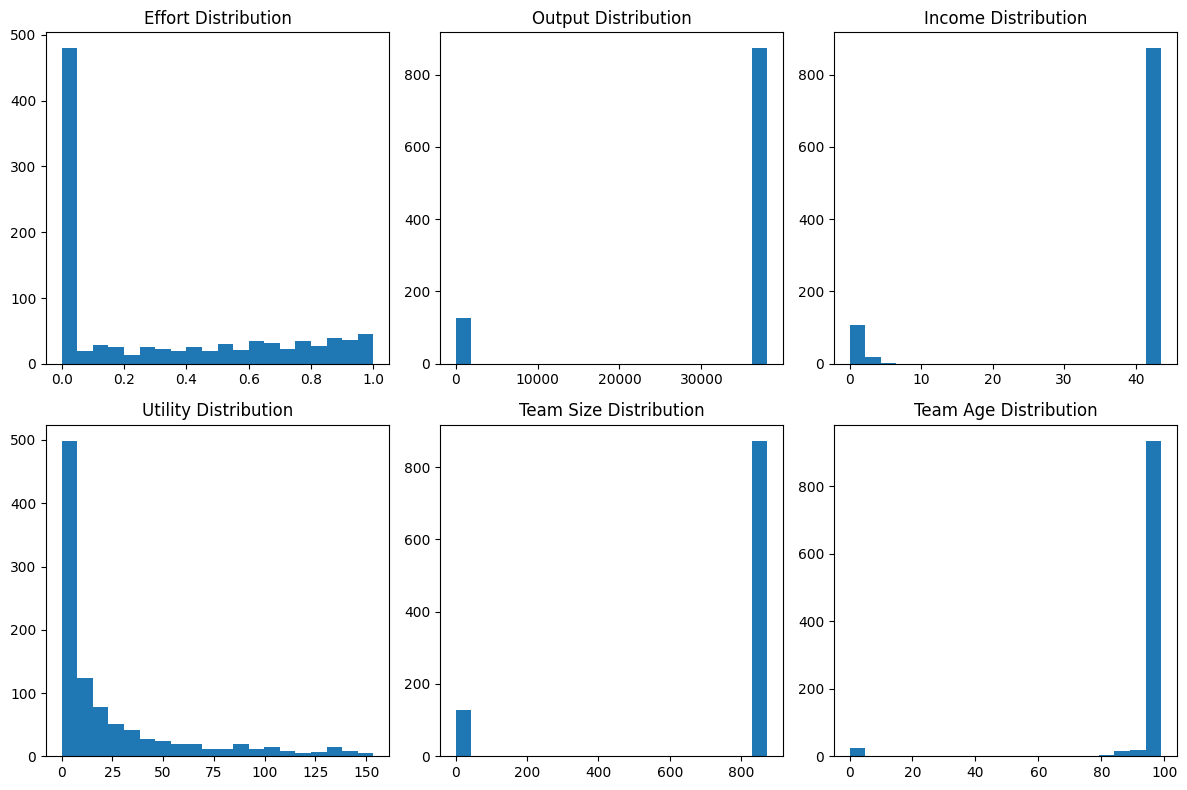

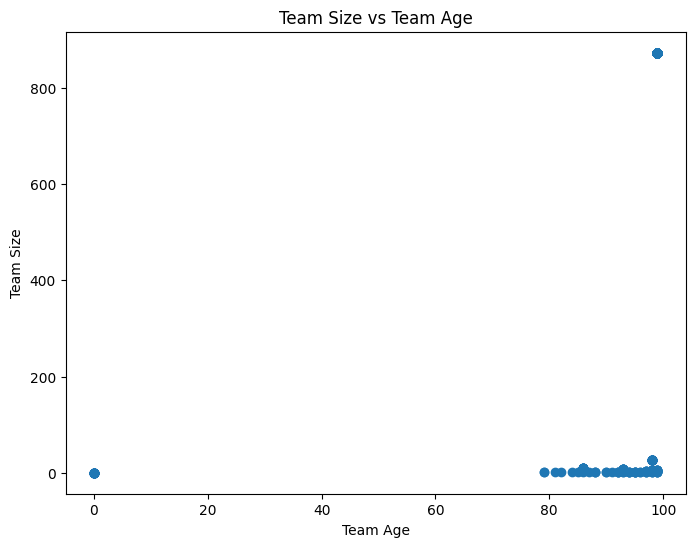

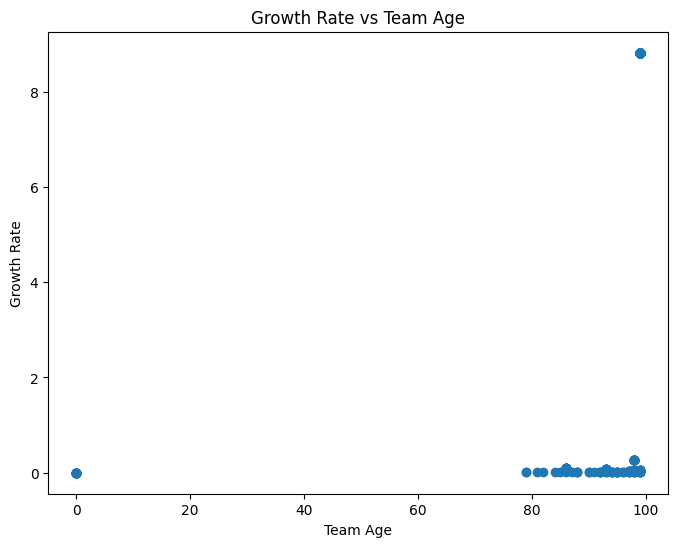


Firm Distributions:
Output - Mean: 6.89, Median: 0.59, Min: 0.00, Max: 271.75
Size - Mean: 22.18, Median: 1.00, Min: 1.00, Max: 873.00
Age - Mean: 93.05, Median: 94.50, Min: 79.00, Max: 99.00
Productivity - Mean: 0.36, Median: 0.32, Min: 0.00, Max: 1.00
Growth Rate - Mean: 0.23, Median: 0.01, Min: 0.01, Max: 8.82

Agent Distributions:
Income - Mean: 37.99, Median: 43.28, Min: 0.00, Max: 43.57
Tenure - Mean: 77.27, Median: 83.00, Min: 0.00, Max: 100.00
Effort - Mean: 0.30, Median: 0.12, Min: 0.00, Max: 1.00
Utility - Mean: 23.98, Median: 7.72, Min: 0.00, Max: 153.53
Network Size - Mean: 3.97, Median: 4.00, Min: 2.00, Max: 6.00


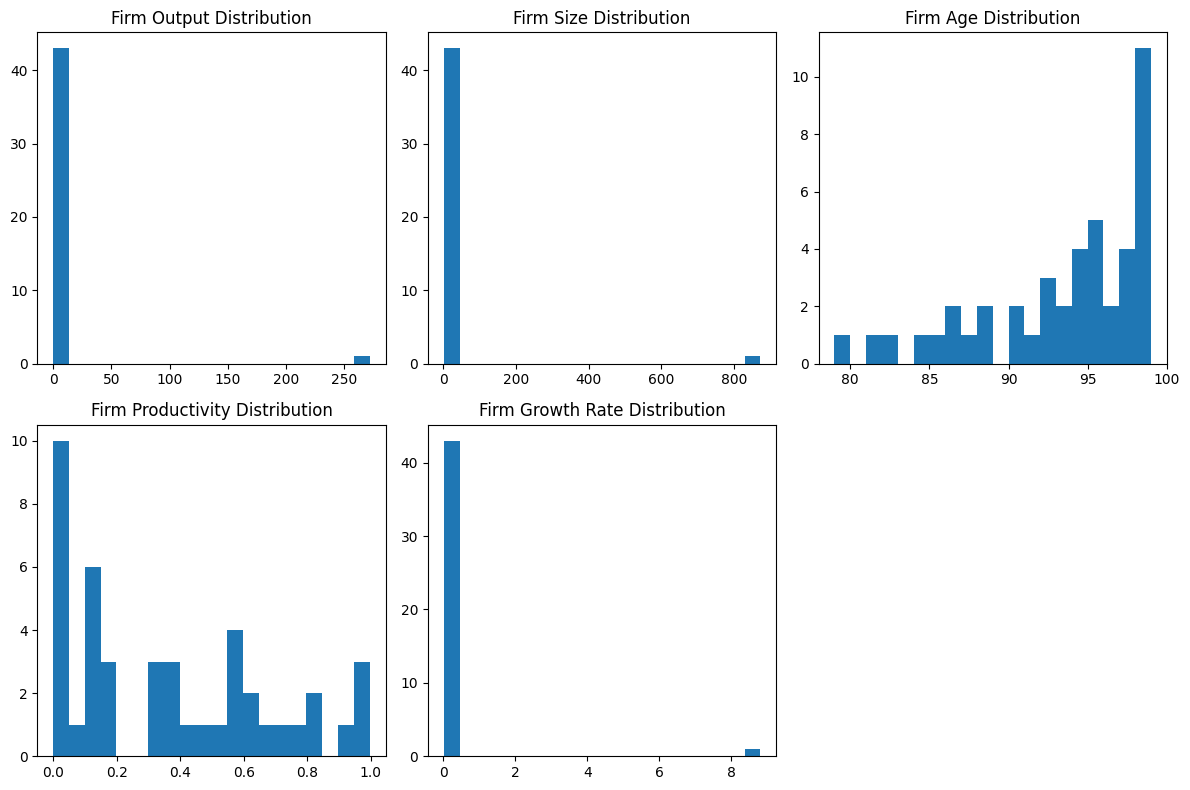

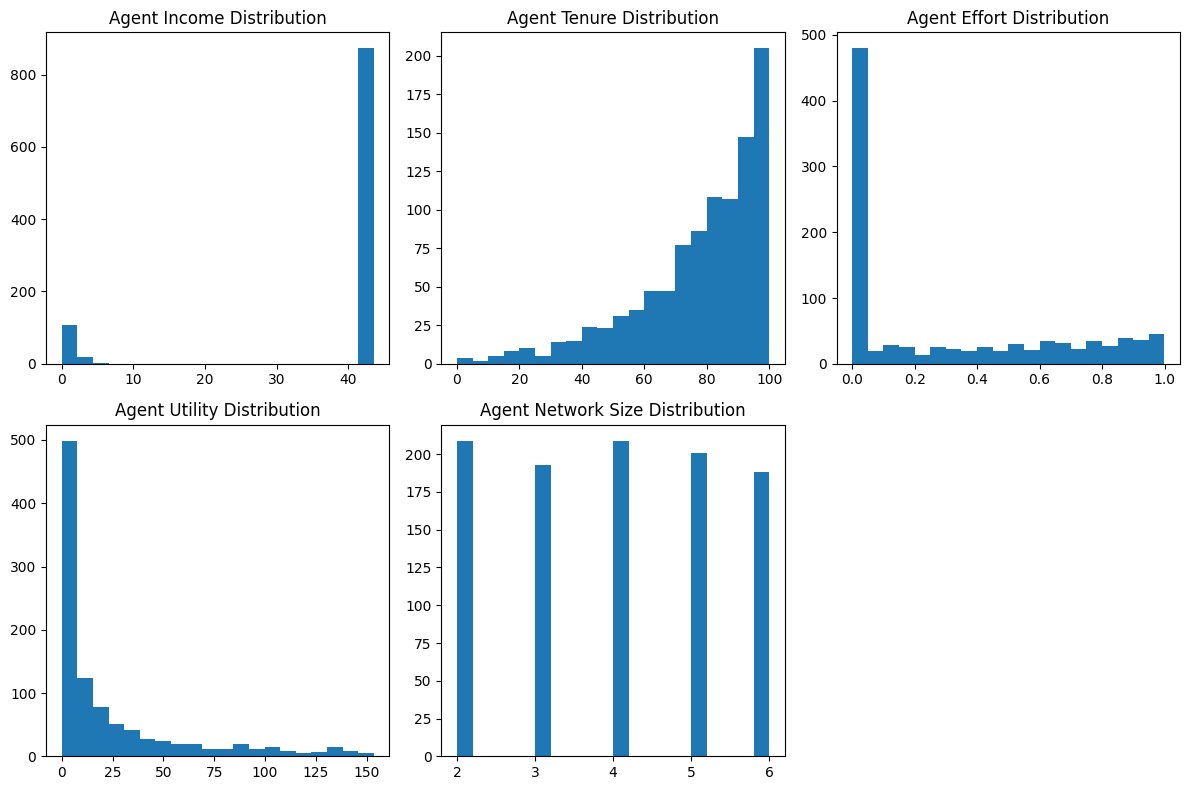

In [109]:
# Базовая конфигурация
num_agents = 1000
num_periods = 100  # Один модельный период = один календарный месяц
agent_id = 0
team_id = 0
agents, teams, efforts, output, income, utility, job_changes = \
    simulate(num_agents, num_periods, False, True)


In [110]:
members_sum = 0
for team in teams:
    if len(team.members) > 0:
        print(f'{len(team.members)}')
        members_sum+=len(team.members)
print(f"Total active members count:{members_sum}")

4
2
1
873
5
1
1
6
1
27
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
2
7
1
2
1
1
1
1
2
9
1
1
1
1
2
1
1
1
Total active members count:976


In [111]:
print(f'{len(teams)}')
print(f'{len(agents)}')

44
1000
